In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Retrieve training data

In [2]:
X_train = pd.read_csv('X_train.csv', index_col=0)

pickle_in = open('y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)

### OLS One Time Function

In [3]:
def onetime_ols(X_train, y_train):
    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    est = ols_model.fit()
    results = est.summary()
    
    return est, results

### OLS Loop Function

In [4]:
def ols_loop(X_train, y_train, run):

    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    est = ols_model.fit()
    results = est.summary()

    # Capture r2_adj 
    r2_adj = est.rsquared_adj

    # Load summary info into dataframe for processing
    results_as_html = results.tables[1].as_html()
    results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={'index':'feature'})
    results_df = results_df[1:]

    # Identify highest p-value in data set
    kill_cols = results_df[results_df['P>|t|'] == results_df['P>|t|'].max()]
    highest_p_col = kill_cols['feature'].values
    highest_p = kill_cols['P>|t|'].values

    # Remove feature with highest p-value
    X_chop = X_train.drop(columns=highest_p_col)

    # Capture values from test in dictionary
    run_dict = {'test_run': run, \
            'r2_adj': r2_adj, \
            'highest_feature': highest_p_col,\
            'highest_pval': highest_p[0]}
    
    return X_chop, run_dict

### View initial residual plot for a basline look at the residuals in the regression

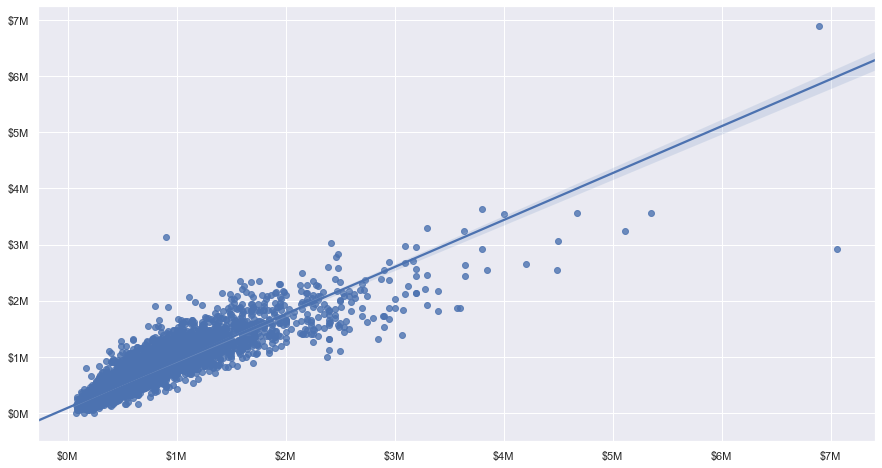

In [5]:
ot_est, results = onetime_ols(X_train, y_train)
results_as_html = results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})

results_df;

onetime_ols(X_train, y_train)

y_pred = ot_est.predict()

# Generate sns regplot
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

tr = sns.regplot(x=y_train, y=y_pred);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in tr.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in tr.get_xticks()/1000000]
tr.set_xticklabels(xlabels);
tr.set_yticklabels(ylabels);

## Look at the residuals as well, yellowbrick package for residual plots
### y_train - y_pred on y and then y_train on x axis

### It appears there are __outliers to be removed__.  This inlcude the y_train values around 7,000,000 and the y_train value corresponding to the maximum y_pred value

Remove y_train outliers

In [6]:
# ind = np.argpartition(y_train, -1)[-2:]
# print(ind)
# print(y_train[ind])

# y_train2 = np.delete(y_train, 7358, 0)
# y_train2 = np.delete(y_train2, 2194, 0)
# x_train2 = X_train.drop(index=7358)
# x_train2 = x_train2.drop(index=2194)

[16147  7358]
[ 467000. 7060000.]


In [ ]:
# ind = np.argpartition(y_pred, -1)[-5:]
# print(ind)
# print(y_pred[ind])

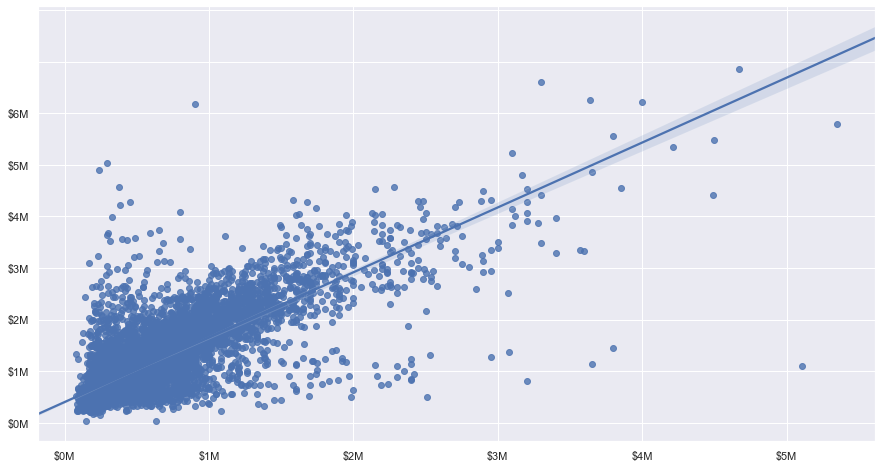

In [9]:
ot_est, results = onetime_ols(x_train2, y_train2)
results_as_html = results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})

results_df;

onetime_ols(x_train2, y_train2)
y_pred1 = ot_est.predict(sm.add_constant(x_train2))

# Plot sns regplot
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

tr2 = sns.regplot(x=y_train2, y=y_pred1);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in tr2.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in tr2.get_xticks()/1000000]
tr2.set_xticklabels(xlabels);
tr2.set_yticklabels(ylabels);

### Loop for recursive feature elimination
Loops removes the highest p_value from an OLS regression and returns the R2 adjusted value and removed feature name

In [10]:
X_train.shape

(16149, 252)

In [11]:
run = 0
for run in range(1, 136):
    if run == 1:
        x_chop, run_dict = ols_loop(x_train2, y_train2, run)
        all_df = pd.DataFrame.from_dict([run_dict])
#         print('Run {} complete'.format(run))
    else:
        x_chop, run_dict = ols_loop(x_chop, y_train2, run)
        run_df = pd.DataFrame.from_dict([run_dict])
        all_df = pd.concat([all_df, run_df])

        # print('Run {} complete'.format(run))

In [15]:
all_df

,test_run,r2_adj,highest_feature,highest_pval
0,1,0.622692,[yr_built_1948],0.990
0,2,0.622716,[bathrooms_0.75],0.987
0,3,0.622740,[yr_built_1907],0.982
0,4,0.622763,[bedrooms_3],0.969
0,5,0.622787,[attic_1],0.966
...,...,...,...,...
0,131,0.622783,[yr_built_1927],0.073
0,132,0.622731,[yr_built_2002],0.068
0,133,0.622676,[yr_built_2005],0.072
0,134,0.622623,[yr_built_2007],0.085


### Review columns returned from ols loop analysis

### Review the recursive feature elimination and save to csv

In [18]:
rfe_results = results_df
rfe_results.to_csv('rfe_results.csv')
rfe_results

,feature,coef,std err,t,P>|t|,[0.025,0.975]
0,const,118300.0,56500.000,2.092,0.036,7452.595,229000.000
1,bathrooms_3.0,22780.0,9754.427,2.336,0.020,3662.702,41900.000
2,bathrooms_3.25,27420.0,11000.000,2.493,0.013,5864.383,49000.000
3,bathrooms_4.0,128400.0,24000.000,5.354,0.000,81400.000,175000.000
4,bathrooms_4.25,103900.0,29000.000,3.578,0.000,47000.000,161000.000
...,...,...,...,...,...,...,...
111,sqft_lot,366300.0,106000.000,3.468,0.001,159000.000,573000.000
112,sqft_above,1118000.0,43300.000,25.819,0.000,1030000.000,1200000.000
113,sqft_basement,455100.0,25200.000,18.061,0.000,406000.000,505000.000
114,sqft_living15,160200.0,27000.000,5.941,0.000,107000.000,213000.000


In [19]:
x_chop.columns
x_model = X_train[x_chop.columns]
x_model = x_model.reset_index()

y_pred2 = ot_est.predict()

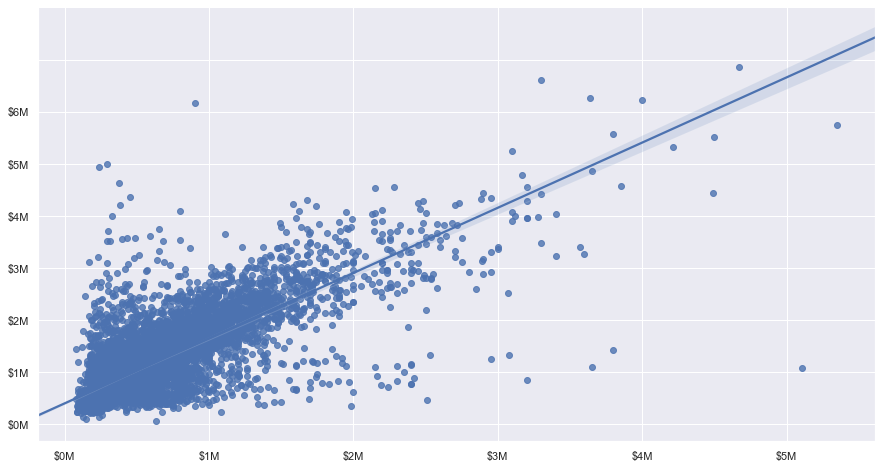

In [20]:
# sns regplot
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

mod = sns.regplot(x=y_train2, y=y_pred2);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in mod.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in mod.get_xticks()/1000000]
mod.set_xticklabels(xlabels);
mod.set_yticklabels(ylabels);